**Sources of information** (last update)

In [248]:
#@title { vertical-output: true, display-mode: "form" }
import pandas as pd
import numpy as np
from datetime import datetime, timedelta


# Consider adding:
#  https://github.com/COVID19Tracking

# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data
# FIPS, Admin2, Province_State, Country_Region, Last_Update, Lat, Long_, Confirmed, Deaths, Recovered, Active, Combined_Key
# Issue: US and others are broken down, while Italy for example is whole
def load_latest_johnhopkins_daily():
    tries = 3
    try_date_utc = datetime.utcnow()
    while True:
        try:
            loc_template = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/%m-%d-%Y.csv"
            try_url = try_date_utc.strftime(loc_template)
            df = pd.read_csv(try_url)
            return also_print_df(df, "John Hopkins", try_date_utc)
        except:
            try_date_utc = try_date_utc - timedelta(days=1)
            tries = tries - 1
            if tries is 0:
                print("Out of tries looking for John Hopkins' data (walking back 1 day at a time)")
                exit(1)


# https://github.com/open-covid-19
#  Date, CountryCode, CountryName, RegionCode, RegionName, Confirmed, Deaths, Latitude, Longitude, Population --- sorted by date, ascending
def load_latest_opencovid_feed():
    loc_template = "https://raw.githubusercontent.com/open-covid-19/data/master/output/data.csv"
    df = pd.read_csv(loc_template)
    last_date = datetime.strptime(df.iloc[-1]['Date'], '%Y-%m-%d')
    return also_print_df(df, "Open COVID-19", last_date)


# https://github.com/pcm-dpc/COVID-19/
#  data, stato, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en
def load_latest_italian_dpc_nationwide_by_date():
    loc_template = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
    df = pd.read_csv(loc_template)
    last_date = datetime.strptime(df.iloc[-1]['data'], '%Y-%m-%dT%H:%M:%S')
    return also_print_df(df, "Italian PCM-DPC (nationwide by date)", last_date)


#  data, stato, codice_regione, denominazione_regione, lat, long, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en
def load_latest_italian_dpc_regional_latest():
    loc_template = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv"
    df = pd.read_csv(loc_template)
    last_date = datetime.strptime(df.iloc[-1]['data'], '%Y-%m-%dT%H:%M:%S')
    return also_print_df(df, "Italian PCM-DPC (regional snapshot)", last_date)

# MISC functions
reference_day = datetime(2020, 1, 1)
def date_to_day_of_year(date):
    return (date - reference_day).days + 1

def day_of_year_to_date(day_of_year):
    return reference_day + timedelta(days=(day_of_year - 1))

def also_print_df(df, name, date):
    print("📈 loaded " + name + " dataset (" + date.strftime("%Y-%m-%d") + "): " +
          "[" + str(len(df)) + " rows x " + str(len(df.columns)) + " columns]: " + ", ".join(list(df)) + "\n")
    return df


# Load the latest data sets
df_jh = load_latest_johnhopkins_daily()
df_oc = load_latest_opencovid_feed()
df_it_nat_daily = load_latest_italian_dpc_nationwide_by_date()
df_it_by_reg = load_latest_italian_dpc_regional_latest()

📈 loaded John Hopkins dataset (2020-03-29): [3434 rows x 12 columns]: FIPS, Admin2, Province_State, Country_Region, Last_Update, Lat, Long_, Confirmed, Deaths, Recovered, Active, Combined_Key

📈 loaded Open COVID-19 dataset (2020-03-30): [12517 rows x 10 columns]: Date, CountryCode, CountryName, RegionCode, RegionName, Confirmed, Deaths, Latitude, Longitude, Population

📈 loaded Italian PCM-DPC (nationwide by date) dataset (2020-03-29): [35 rows x 14 columns]: data, stato, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_guariti, deceduti, totale_casi, tamponi, note_it, note_en

📈 loaded Italian PCM-DPC (regional snapshot) dataset (2020-03-29): [21 rows x 18 columns]: data, stato, codice_regione, denominazione_regione, lat, long, ricoverati_con_sintomi, terapia_intensiva, totale_ospedalizzati, isolamento_domiciliare, totale_attualmente_positivi, nuovi_attualmente_positivi, dimessi_g

***Top countries by Percentage of confirmed cases***

The countries below are sorted by Confirmed cases, and have:
* more than 1000 confirmed cases, and
* a population larger than 10 million people


In [249]:
# Date, Day_of_2020, CountryName, Confirmed, Deaths, Population, Confirmed_Share, Deaths_Share
def oc__get_countries_by_day(df):
    # [select rows] remove regional data
    df = df[df['RegionCode'].isna()]

    # [snr] remove countries with no population data (Kosovo and Antilles) - for uniformity
    df = df[df['Population'].notna()]
    
    # [add column] day of the year 2020
    df['X'] = df['Date'].map(lambda d: date_to_day_of_year(datetime.strptime(d, '%Y-%m-%d')))

    # [select columns] take only the columns we care about
    df = df.loc[:, ['Date', 'X', 'CountryName', 'Confirmed', 'Deaths', 'Population']]

    # [add columns] normalize Confirmed and Deaths to the population (%)
    df['Death_rate'] = 100 * df['Deaths'] / df['Confirmed']
    df['Confirmed_pct'] = 100 * df['Confirmed'] / df['Population']
    df['Deaths_pct'] = 100 * df['Deaths'] / df['Population']
    return df


def oc__get_ranked_countries(df, metric='Confirmed', min_population=10E+06, min_confirmed=5000):
    # [unique] use the last frame of data (the freshest), unique by country
    df = df.drop_duplicates('CountryName', keep='last')

    # [snr] remove countries with fewer than this people
    df = df[df['Population'] > min_population]

    # [snr] remove countries with fewer than these cases
    df = df[df['Confirmed'] > min_confirmed]

    # [sort] by the metric, descending
    df = df.sort_values(metric, ascending=False)
    return df


# get clean daily data for all countries from the 'Open-Covid-19' dataset
countries_daily = oc__get_countries_by_day(df_oc)
countries_ranked = oc__get_ranked_countries(countries_daily, metric='Confirmed')
countries_ranked

,Date,X,CountryName,Confirmed,Deaths,Population,Death_rate,Confirmed_pct,Deaths_pct
12499,2020-03-29,89,United States of America,124665.0,2191.0,3.290649e+08,1.757510,0.037885,0.000666
12516,2020-03-30,90,Italy,97689.0,10779.0,6.055008e+07,11.033996,0.161336,0.017802
12284,2020-03-29,89,China,82342.0,3306.0,1.433784e+09,4.014962,0.005743,0.000231
12515,2020-03-30,90,Spain,78797.0,6528.0,4.673678e+07,8.284579,0.168597,0.013968
12308,2020-03-29,89,Germany,52547.0,389.0,8.351704e+07,0.740290,0.062918,0.000466
12358,2020-03-29,89,France,37575.0,2314.0,6.512973e+07,6.158350,0.057693,0.003553
12385,2020-03-29,89,Iran,35408.0,2517.0,8.291391e+07,7.108563,0.042705,0.003036
12360,2020-03-29,89,United Kingdom,17089.0,1019.0,6.753017e+07,5.962900,0.025306,0.001509
12452,2020-03-29,89,Netherlands,9762.0,639.0,1.709713e+07,6.545790,0.057097,0.003737
12417,2020-03-29,89,South Korea,9583.0,152.0,5.122531e+07,1.586142,0.018708,0.000297



**Some chart**

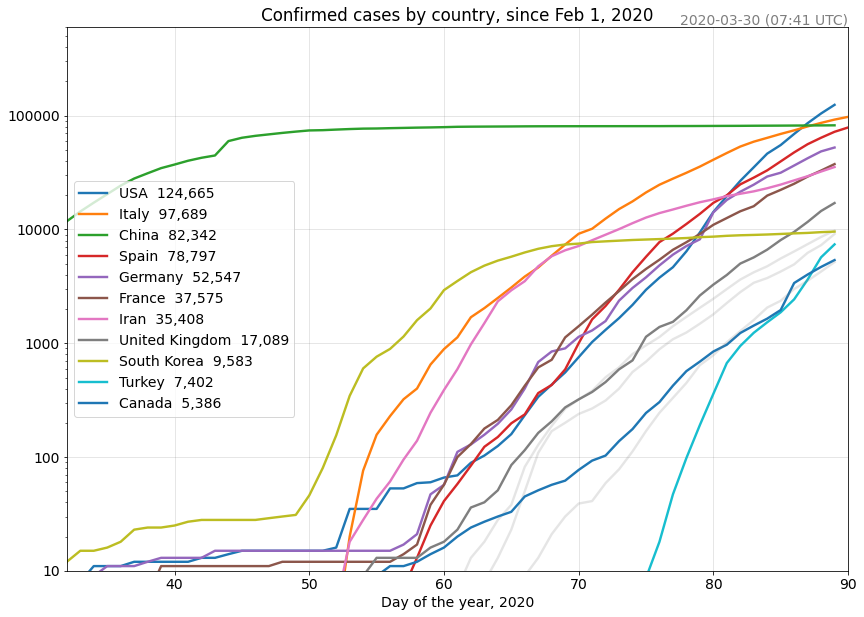

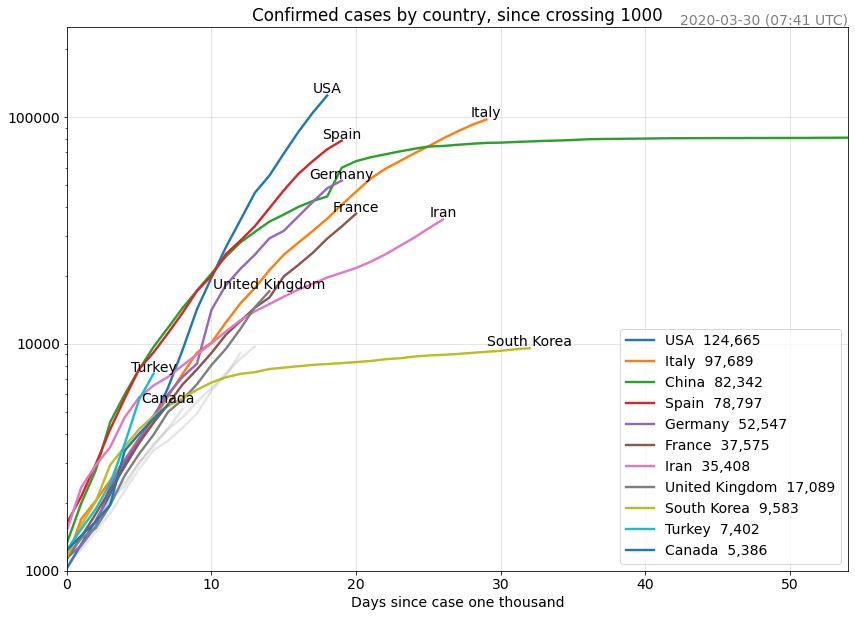

In [250]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter


# Utility function to scatter-plot dataframes (multiple series)
def create_xy_plot_by_series(_df,
                             y_key, x_key, series_key, series_values,
                             y_log=False, shift_x_to_intersect_y=None,
                             bounds=[None,None,None,None],
                             is_series_secondary_function=None,
                             legend_decimals=0, 
                             data_labels=None,                  # label text: legend, series, value
                             data_labels_alignment="center",    # label alignment: left, right, center
                             title=None, label_x=None, label_y=None, stamp_1=None, stamp_2=None):
    # label the plot
    plt.rc('font', size=14)
    plt.figure(figsize=(14, 10))
    plt.title(title if title else "'" + y_key + "' over '" + x_key + "', by '" + series_key + "'")
    if not label_x:
        label_x = x_key
        if shift_x_to_intersect_y:
            label_x = label_x + " since crossing " + str(shift_x_to_intersect_y)
    plt.xlabel(label_x)
    if label_y: plt.ylabel(label_y)
    if not stamp_1: stamp_1 = "" + datetime.now().strftime("%Y-%m-%d (%H:%M UTC)")
    #if not stamp_2: stamp_2 = "Countries with >1M people and >1K cases"

    # add the lines for all the 'countries to chart'
    all_x = []
    all_y = []
    for series_value in series_values:
        # [select rows] get the data of a single series (e.g. a country)
        df = _df[_df[series_key] == series_value]

        # [cleanup] remove 0's, as they don't play well with log
        df = df[df[y_key] > 0]

        # find when the series crosses 100
        x_translation = 0
        if shift_x_to_intersect_y:
            exceeding = df[df[y_key] >= shift_x_to_intersect_y]
            if len(exceeding) == 0:
                continue
            x_translation = -exceeding.iloc[0][x_key]

        # checks if this element should be grayed out
        secondary = is_series_secondary_function(df) if is_series_secondary_function else False

        # text of the label (and shorten 'USA')
        series_label = series_value if series_value != "United States of America" else "USA"
        metric_label = round(df[y_key].iloc[-1], legend_decimals)
        if legend_decimals == 0: metric_label = metric_label.astype(int)
        legend_label = series_label + "  " + str(format(metric_label, ',')) + ""
        if secondary: legend_label = None
        
        # format the color and size
        line_color = (0.5, 0.5, 0.5, 0.2) if secondary else None

        # add the series data
        x = (df[x_key] + x_translation).tolist()
        y = df[y_key].tolist()
        y_filtered = df[y_key].rolling(window=(7, 20), win_type='exponential').mean(tau=20)
        #plt.plot(x, y, color=(0.8, 0.8, 0.8, 0.2), linewidth=1)
        plt.plot(x, y, label=legend_label, color=line_color, linewidth=2.4)
        # plt.scatter(x, y, color=line_color, linewidth=1, alpha=1)

        # add the data label on the endpoint
        if data_labels and not secondary:
            point_label = None
            if data_labels == "series":
                point_label = series_label
            elif data_labels == "value":
                point_label = str(metric_label)
            if data_labels == "legend":
                point_label = legend_label
            # PATCH: remove the label for China in the second chart, or it will be scaled down
            if shift_x_to_intersect_y and series_label == "China": point_label = None
            if point_label:
                plt.annotate(point_label, 
                    (x[-1], y[-1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,2), # distance from text to points (x,y)
                    annotation_clip=False,
                    ha=data_labels_alignment) # horizontal alignment can be left, right or center

        # for auto bounds
        all_x.extend(x)
        all_y.extend(y)
    
    # X/Y axes: set-up ranges and scale type
    # boundaries = [left, right, min_y, max_y] <- automatic if any is set to None
    if not bounds: bounds = [None, None, None, None]
    auto_bounds = [min(all_x), max(all_x), np.floor(min(all_y)), np.ceil(max(all_y))]
    bounds = list(map(lambda pair: pair[0] if pair[0] != None else pair[1], zip(bounds, auto_bounds)))
    if shift_x_to_intersect_y:
        bounds[0] = 0
        bounds[1] = bounds[1] - 10 # magic number, shall remove
        bounds[2] = shift_x_to_intersect_y
    if y_log: 
        plt.yscale('log')
        plt.gca().yaxis.set_major_formatter(ScalarFormatter())
        bounds[3] = 2 * bounds[3]
    plt.xlim(bounds[0], bounds[1])
    plt.ylim(bounds[2], bounds[3])

    # add grid
    plt.gca().grid(axis='both', color=(0.4, 0.4, 0.4), alpha=0.2)

    # add legend
    plt.legend()

    # add any decorative text boxes
    if stamp_1:
        plt.text(1, 1, stamp_1, transform=plt.gca().transAxes, alpha=0.5,
                 horizontalalignment='right', verticalalignment='bottom')
    if stamp_2:
        plt.text(1, -0.04, stamp_2, transform=plt.gca().transAxes, alpha=0.5,
                 horizontalalignment='right', verticalalignment='top')
    return plt


def is_population_less_than_20M(df_series):
    latest_population = df_series['Population'].iloc[-1].astype(int)
    return latest_population < 20E+06

def is_population_less_than_40M(df_series):
    latest_population = df_series['Population'].iloc[-1].astype(int)
    return latest_population < 40E+06


# Chart 1: by time
plot = create_xy_plot_by_series(
    _df=countries_daily,
    title='Confirmed cases by country, since Feb 1, 2020',
    label_x='Day of the year, 2020',
    y_key='Confirmed',
    x_key='X',
    series_key='CountryName', series_values=countries_ranked['CountryName'],
    y_log=True,
    bounds=[date_to_day_of_year(datetime(2020, 2, 1)),None, 10, 300000],
    is_series_secondary_function=is_population_less_than_20M,
)
plot.show()

# Chart 2: Snapped
plot = create_xy_plot_by_series(
    _df=countries_daily,
    title='Confirmed cases by country, since crossing 1000',
    label_x='Days since case one thousand',
    y_key='Confirmed',
    x_key='X',
    series_key='CountryName',
    series_values=countries_ranked['CountryName'],
    y_log=True,
    shift_x_to_intersect_y=1000,
    data_labels="series",
    data_labels_alignment="center",
    is_series_secondary_function=is_population_less_than_20M,
)
plot.show()

Mortality rate by time

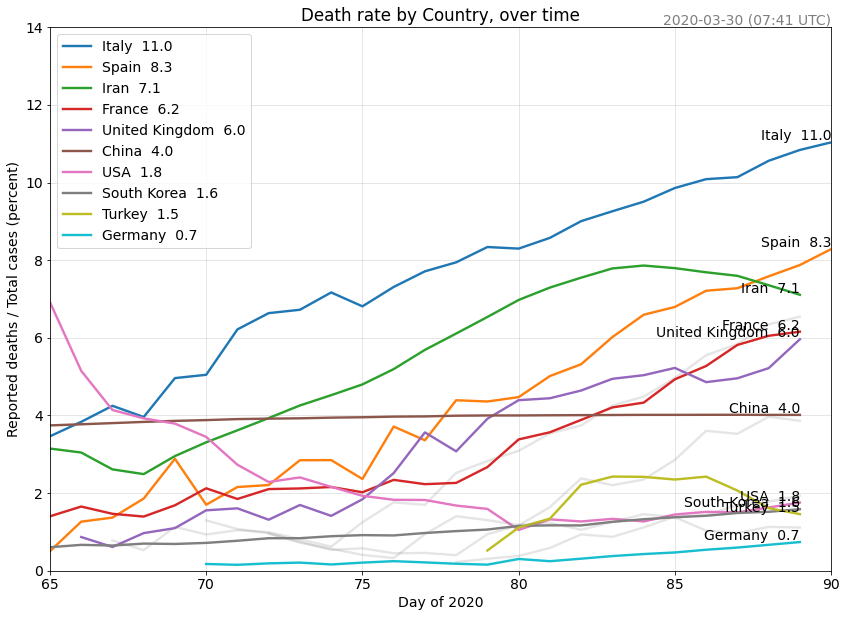

In [257]:
plot = create_xy_plot_by_series(
    _df=countries_daily,
    title="Death rate by Country, over time",
    label_x="Day of 2020",
    label_y="Reported deaths / Total cases (percent)",
    y_key='Death_rate',
    x_key='X',
    series_key='CountryName',
    series_values=oc__get_ranked_countries(countries_daily, metric='Death_rate')['CountryName'],
    y_log=False,
    #shift_x_to_intersect_y=5,
    bounds=[65,None, 0,14],
    legend_decimals=1,
    data_labels="legend",
    data_labels_alignment="right",
    is_series_secondary_function=is_population_less_than_40M,
)
plot.show()